# Practicioners Seminar - Task 2

TODO:

- Add optimized hedge ratio approach from Tobias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.formula.api import ols

### Load and prepare data

In [2]:
# Daily Data

# Paths
currencies = "Data/FX_CHF_ALL_1971-2020.xlsx"
interest_rates = "Data/3M_interest_rates.xlsx"
msci_all_local = "Data/MSCI_ALL_LOCAL.xlsx"
msci_world_total_return_h_chf = "Data/Msci World hCHF.xlsx"
msci_world_total_return_chf = "Data/MSCI_World_total_return_chf.xlsx"

# FX
df_fx_indirect = pd.read_excel(currencies, header=0, index_col=0, sheet_name="Sheet1")
df_fx_direct = 1 / df_fx_indirect
df_fx_direct = df_fx_direct.replace([np.inf, -np.inf], np.nan)
df_fx_direct.columns = ['USDCHF', 'EURCHF', 'GBPCHF', 'AUDCHF', 'JPYCHF', 'CADCHF']

# MSCI
df_msci_local = pd.read_excel(msci_all_local, header=3, index_col=0, sheet_name="CleanTimeSeries")
df_msci_local = df_msci_local.sort_index()
df_msci_world_chf = pd.read_excel(msci_world_total_return_chf, header=18, index_col=0)
df_msci_world_chf = df_msci_world_chf['Close'].dropna().sort_index()
df_msci_world_h_chf = pd.read_excel(msci_world_total_return_h_chf, header=0, index_col=0)
df_msci_world_h_chf = df_msci_world_h_chf.dropna().sort_index()

# Interest rates
df_r = pd.read_excel(interest_rates, header=1, index_col=0)
df_r.columns = ['CHF', 'USD', 'EUR', 'GBP', 'JPY', 'CAD', 'AUD']
df_r = df_r/100
df_r = df_r[df_r!=0].dropna()

# Monthly Data

# Paths
msci_all_local_m = "Data/MSCI_ALL_LOCAL_MONTHLY.xlsx"
msci_all_usd_chf_m = "Data/MSCI_ALL_USD_CHF_MONTHLY.xlsx"

# FX
df_fx_direct_m = df_fx_direct.resample('M').last()

# MSCI
df_msci_local_m = pd.read_excel(msci_all_local_m, header=0, index_col=0).sort_index()
df_msci_usd_chf_m = pd.read_excel(msci_all_usd_chf_m, header=0, index_col=0).sort_index()
df_msci_world_chf_m = df_msci_world_chf.resample('M').last()
df_msci_world_h_chf_m = df_msci_world_h_chf.resample('M').last()

# Interest rates
df_r_m = df_r.resample('M').last()
df_r_m = df_r_m[df_r_m!=0].dropna()


In [3]:
# Function to get forward rates
def fx_forward(currency_pair, t, t_1, fx, interest_rates):
    """Useage:
    date_1 = pd.Timestamp('2020-12-16')
    date_2 = pd.Timestamp('2020-12-18')
    fx_forward('USDCHF', date_1, date_2, df_fx, df_r)
    """
    # Get spot exchange rate and LIBOR rates
    s = fx.loc[t, currency_pair]
    r_d = interest_rates.loc[t, currency_pair[3:]]
    r_f = interest_rates.loc[t, currency_pair[:3]]
    
    # Calculate number of days
    n_days = t_1 - t
    n_days = n_days.days
    
    # Forward rate
    f = np.log(s) + np.log(1+r_d)*n_days/365 - np.log(1+r_f)*n_days/365
    
    return np.exp(f)
    

In [4]:
# Create a df with daily forward rates
df_f_daily = pd.DataFrame(index=df_r.index, columns=df_fx_direct.columns)
df_f_daily = df_f_daily.sort_index()
for d in range(len(df_f_daily.index)-1):
    for c in range(len(df_f_daily.columns)):
        try:
            df_f_daily.iloc[d, c] = fx_forward(df_f_daily.columns[c], df_f_daily.index[d], df_f_daily.index[d+1], df_fx_direct, df_r)
        except KeyError:
            df_f_daily.iloc[d, c] = np.nan


In [5]:
# To exclude currency effects in correlations, we need MSCI returns hedged to CHF. This are price indices, not total return indices.

# FX Hedged MSCI Returns
df_msci_local_chf = df_msci_local.copy()
df_msci_local_chf = np.log(df_msci_local_chf.sort_index()).diff()

# Now they are USD hedged returns, change to CHF hedged returns

# MSCI World and US are denoted in USD
df_msci_local_chf['MSDLWI Index'] = df_msci_local_chf['MSDLWI Index'] * df_fx_direct['USDCHF'] / df_f_daily['USDCHF'].shift()
df_msci_local_chf['MXUS Index'] = df_msci_local_chf['MXUS Index'] * df_fx_direct['USDCHF'] / df_f_daily['USDCHF'].shift()

# MSCI Europe is denoted in EUR
df_msci_local_chf['MSDLE15 Index'] = df_msci_local_chf['MSDLE15 Index'] * df_fx_direct['EURCHF'] / df_f_daily['EURCHF'].shift()

# MSCI Australia is denoted in AUD
df_msci_local_chf['MSDLAS Index'] = df_msci_local_chf['MSDLAS Index'] * df_fx_direct['AUDCHF'] / df_f_daily['AUDCHF'].shift()

# MSCI Canada is denoted in CAD
df_msci_local_chf['MSDLCA Index'] = df_msci_local_chf['MSDLCA Index'] * df_fx_direct['CADCHF'] / df_f_daily['CADCHF'].shift()

# MSCI Japan is denoted in JPY
df_msci_local_chf['MSDLJN Index'] = df_msci_local_chf['MSDLJN Index'] * df_fx_direct['JPYCHF'] / df_f_daily['JPYCHF'].shift()

# MSCI UK is denoted in GBP
df_msci_local_chf['MSDLUK Index'] = df_msci_local_chf['MSDLUK Index'] * df_fx_direct['EURCHF'] / df_f_daily['EURCHF'].shift()

# Drop columns with NA
df_msci_local_chf = df_msci_local_chf[df_msci_local_chf!=0].dropna()
df_msci_local_chf = df_msci_local_chf.replace([np.inf, -np.inf], np.nan)

# Combine with FX returns data
df_fx_direct_ret = np.log(df_fx_direct.sort_index()).diff()
df_msci_fx_ret = pd.concat([df_msci_local_chf, df_fx_direct_ret], axis=1, join="inner")


# Daily correlation MSCI World and FX
df_msci_w_fx_ret = df_msci_fx_ret[df_fx_direct.columns]
df_msci_w_fx_ret.loc[:,'M0WOHCHF Index'] = np.log(df_msci_world_h_chf['M0WOHCHF Index']).diff()

/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [6]:
# Create a df with monthly forward rates
df_f_m = pd.DataFrame(index=df_msci_local_m.index, columns=df_fx_direct_m.columns)
df_f_m = df_f_m.sort_index()
for d in range(len(df_f_m.index)-1):
    for c in range(len(df_f_m.columns)):
        try:
            df_f_m.iloc[d, c] = fx_forward(df_f_m.columns[c], df_f_m.index[d], df_f_m.index[d+1], df_fx_direct_m, df_r_m)
        except KeyError:
            df_f_m.iloc[d, c] = np.nan

In [7]:
# Unhedged MSCI Returns
df_msci_usd_chf_m = np.log(df_msci_usd_chf_m.sort_index()).diff()

# FX Hedged MSCI Returns
df_msci_local_chf_m = df_msci_local_m.copy()
df_msci_local_chf_m = np.log(df_msci_local_chf_m.sort_index()).diff()

# Now they are USD hedged returns, change to CHF hedged returns

# MSCI World and US are denoted in USD
df_msci_local_chf_m['MSDLWI Index'] = df_msci_local_chf_m['MSDLWI Index'] * df_fx_direct_m['USDCHF'] / df_f_m['USDCHF'].shift()
df_msci_local_chf_m['MXUS Index'] = df_msci_local_chf_m['MXUS Index'] * df_fx_direct_m['USDCHF'] / df_f_m['USDCHF'].shift()

# MSCI Europe is denoted in EUR
df_msci_local_chf_m['MSDLE15 Index'] = df_msci_local_chf_m['MSDLE15 Index'] * df_fx_direct_m['EURCHF'] / df_f_m['EURCHF'].shift()

# MSCI Australia is denoted in AUD
df_msci_local_chf_m['MSDLAS Index'] = df_msci_local_chf_m['MSDLAS Index'] * df_fx_direct_m['AUDCHF'] / df_f_m['AUDCHF'].shift()

# MSCI Canada is denoted in CAD
df_msci_local_chf_m['MSDLCA Index'] = df_msci_local_chf_m['MSDLCA Index'] * df_fx_direct_m['CADCHF'] / df_f_m['CADCHF'].shift()

# MSCI Japan is denoted in JPY
df_msci_local_chf_m['MSDLJN Index'] = df_msci_local_chf_m['MSDLJN Index'] * df_fx_direct_m['JPYCHF'] / df_f_m['JPYCHF'].shift()

# MSCI UK is denoted in GBP
df_msci_local_chf_m['MSDLUK Index'] = df_msci_local_chf_m['MSDLUK Index'] * df_fx_direct_m['EURCHF'] / df_f_m['EURCHF'].shift()

# Drop columns with NA
df_msci_local_chf_m = df_msci_local_chf_m[df_msci_local_chf_m!=0].dropna()
df_msci_local_chf_m = df_msci_local_chf_m.replace([np.inf, -np.inf], np.nan)

# Combine with FX rate data
df_fx_direct_ret_m = np.log(df_fx_direct_m.sort_index()).diff()

# Combine the df
df_msci_fx_ret_m = pd.concat([df_msci_local_chf_m, df_fx_direct_ret_m], axis=1, join="inner")
df_msci_fx_ret_m = df_msci_fx_ret_m[df_msci_fx_ret_m!=0].dropna()

# Df with only MSCI World and FX
df_msci_w_fx_ret_m = df_msci_fx_ret_m[df_fx_direct_m.columns]
df_msci_w_fx_ret_m.loc[:,'M0WOHCHF Index'] = np.log(df_msci_world_h_chf_m['M0WOHCHF Index']).diff()

/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Correlation Plots
### Daily return correlations

In [8]:
# Daily correlations
df_msci_w_fx_ret.corr()

,USDCHF,EURCHF,GBPCHF,AUDCHF,JPYCHF,CADCHF,M0WOHCHF Index
USDCHF,1.000000,0.550425,0.641895,0.472790,0.616645,0.706350,0.070604
EURCHF,0.550425,1.000000,0.656324,0.603651,0.353684,0.621689,0.228867
GBPCHF,0.641895,0.656324,1.000000,0.582468,0.387015,0.649437,0.230323
AUDCHF,0.472790,0.603651,0.582468,1.000000,0.206330,0.695572,0.473760
JPYCHF,0.616645,0.353684,0.387015,0.206330,1.000000,0.355382,-0.222823
CADCHF,0.706350,0.621689,0.649437,0.695572,0.355382,1.000000,0.397947
M0WOHCHF Index,0.070604,0.228867,0.230323,0.473760,-0.222823,0.397947,1.000000


In [9]:
# Monthly correlations
df_msci_w_fx_ret_m.corr()

,USDCHF,EURCHF,GBPCHF,AUDCHF,JPYCHF,CADCHF,M0WOHCHF Index
USDCHF,1.000000,0.373793,0.597124,0.270888,0.597186,0.606487,-0.126119
EURCHF,0.373793,1.000000,0.569780,0.553501,0.160581,0.566535,0.241451
GBPCHF,0.597124,0.569780,1.000000,0.463737,0.255117,0.619039,0.165808
AUDCHF,0.270888,0.553501,0.463737,1.000000,0.116849,0.676518,0.534362
JPYCHF,0.597186,0.160581,0.255117,0.116849,1.000000,0.326955,-0.316284
CADCHF,0.606487,0.566535,0.619039,0.676518,0.326955,1.000000,0.348906
M0WOHCHF Index,-0.126119,0.241451,0.165808,0.534362,-0.316284,0.348906,1.000000


### Rolling Correlations

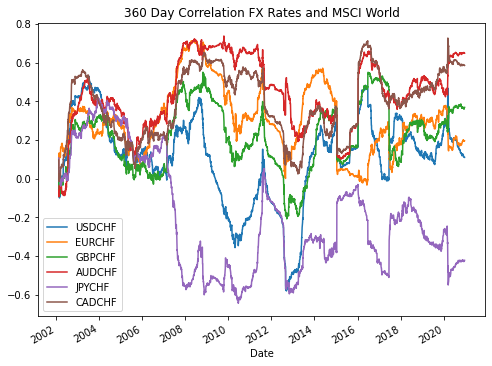

In [10]:
# 360 Day rolling correlations
df_msci_w_fx_ret[df_fx_direct.columns].rolling('360D', min_periods=40).corr(df_msci_w_fx_ret['M0WOHCHF Index']).plot()

# Set figure size and save
figure = plt.gcf()
figure.set_size_inches(8, 6)

plt.title('360 Day Correlation FX Rates and MSCI World')
plt.savefig('Plots/MSCIWorld_FX_RollingCorrelations360D.jpg', dpi=300)

### Correlation heatmap

<AxesSubplot:>

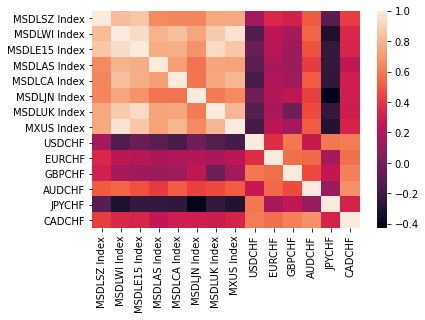

In [11]:
sns.heatmap(df_msci_fx_ret_m.corr(), xticklabels=df_msci_fx_ret_m.columns.values, yticklabels=df_msci_fx_ret_m.columns.values)

### Scatterplot of all MSCI World - FX Correlations

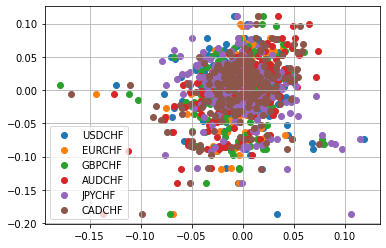

In [12]:
fig, ax = plt.subplots()
for currency in df_fx_direct.columns:
    ax.scatter(df_msci_fx_ret_m[currency], df_msci_fx_ret_m['MSDLWI Index'], label=currency)
ax.legend()
ax.grid(True)

### Pairplot MSCI World and FX rates

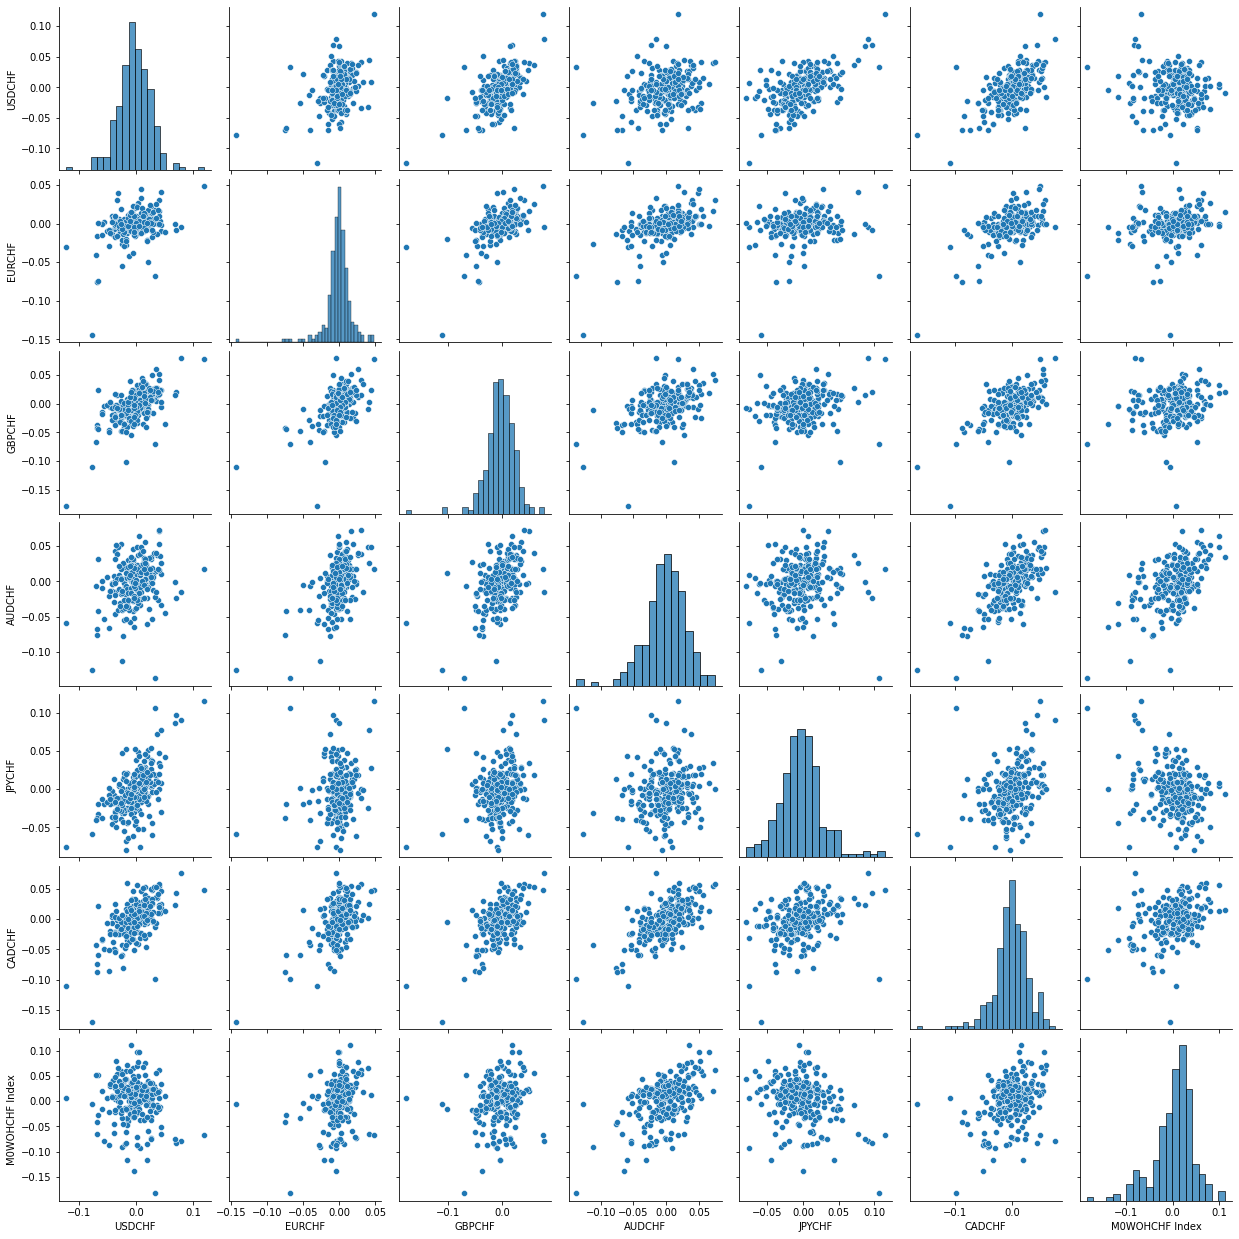

In [13]:
sns.pairplot(df_msci_w_fx_ret_m)

### Pairplot with densities

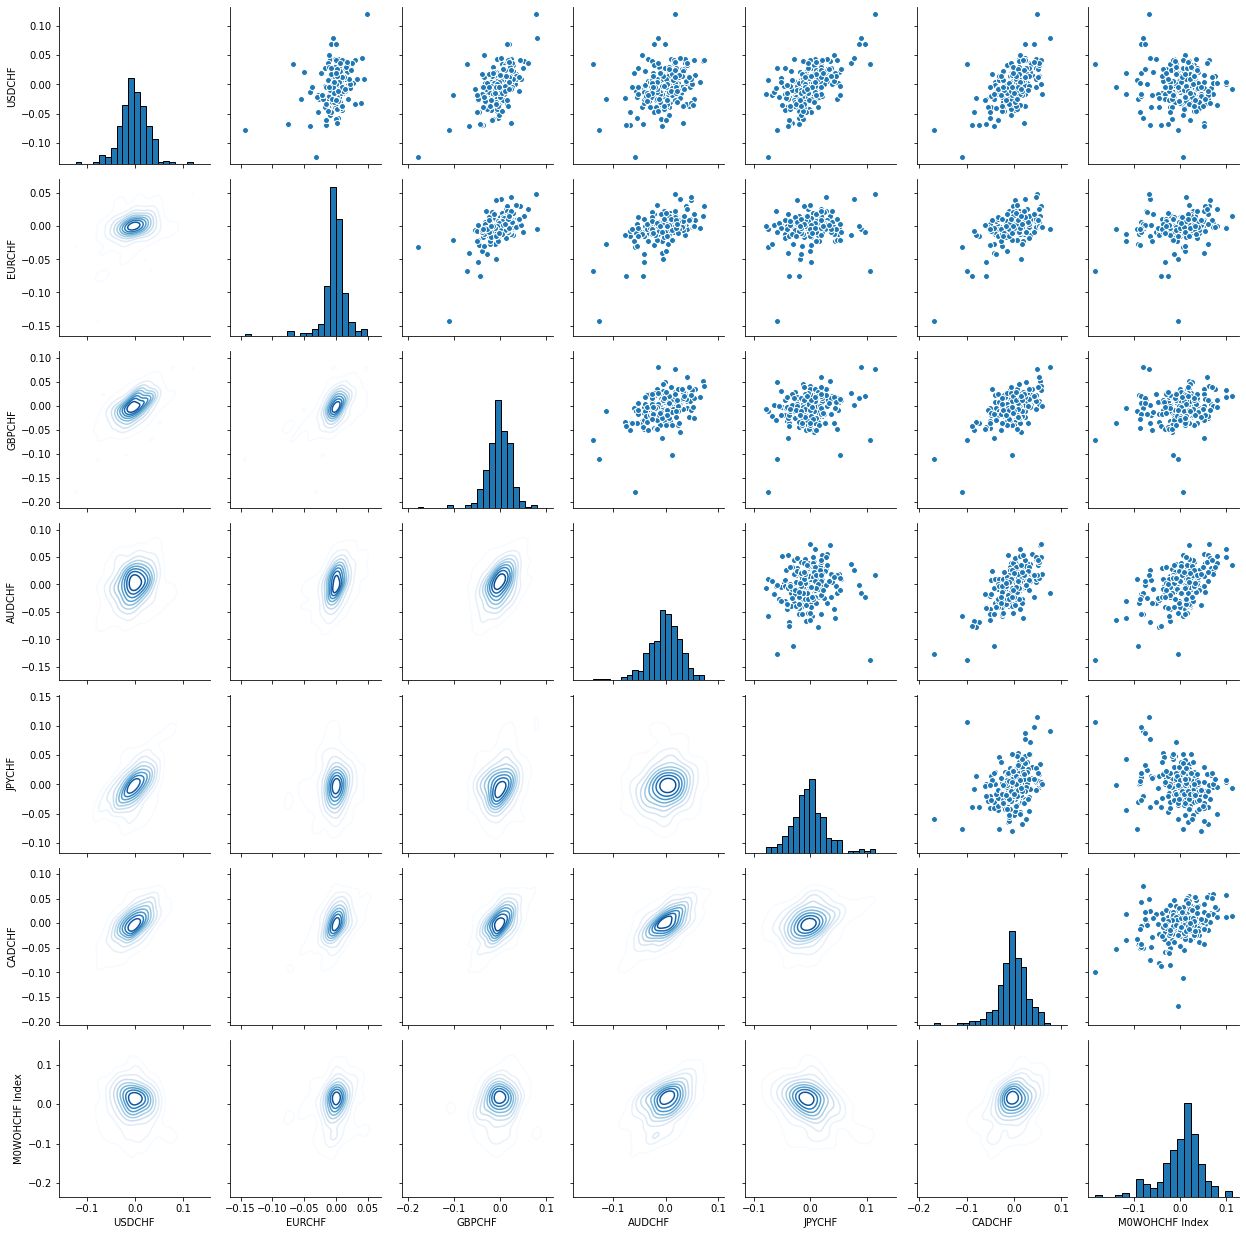

In [14]:
# Gridplot
grid = sns.PairGrid(data=df_msci_w_fx_ret_m)
grid = grid.map_upper(plt.scatter, edgecolor = 'white')
grid = grid.map_diag(plt.hist, bins = 20, 
                     edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = 'Blues')
grid.savefig('Plots/FX_MSCIWorld_PairCorrelation_Monthly.jpg')

## Create partially hedged MSCI World Index

### Rolling Regression to get country and currency weights
Based on daily data

In [15]:
# Create a df of country price indices of all 23 MSCI World Constituent Countries

# Read all filenames in folder
from os import walk
_, _, filenames = next(walk('Data/MSCI_WORLD_CONSTITUENTS'))
filenames.remove('.DS_Store')
df_msci_constituents = pd.DataFrame()
msci_constituent_currency = {}

# Read each file and add it to the df
for file in filenames:
    # Get name and currency of country
    country = file[5:]
    country = country[0:country.find('_')]
    currency = file[len(file)-8:len(file)-5]
    msci_constituent_currency[country] = currency
    
    # Read the country index data and append to df
    df = pd.read_excel('Data/MSCI_WORLD_CONSTITUENTS/' + file, header=16, index_col=0)
    df = df['Close']
    df = pd.DataFrame({country:df})
    df = df.sort_index()
    
    # Add empty df with difference of indexes. Maybe more elegant way to do this?
    df_empty = pd.DataFrame(columns=[country], index=df.index.difference(df_msci_constituents.index))
    df_msci_constituents = df_msci_constituents.append(df_empty)
    df_msci_constituents[country] = df

# Add the hedged MSCI World price index, to make sure we only include days where all data are available
df_msci_constituents = df_msci_constituents.sort_index()
df_msci_constituents['World'] = df_msci_local['MSDLWI Index']
df_msci_constituents_ret = np.log(df_msci_constituents).diff()
df_msci_constituents_ret = df_msci_constituents_ret[df_msci_constituents_ret!=0].dropna()


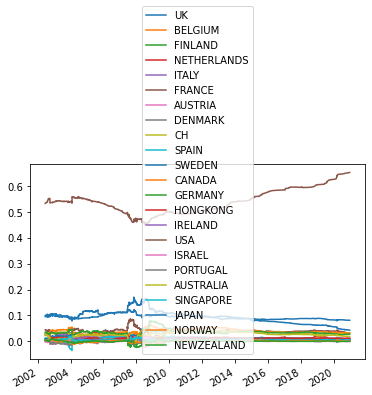

In [16]:
# Use the RollingOLS function to get rolling loading of MSCI World on MSCI Country indices, 
# and therefore the country weights
y = df_msci_constituents_ret['World']
all_countries = df_msci_constituents_ret.columns.drop("World")
x = df_msci_constituents_ret[all_countries]

ols = RollingOLS(y, x, window=252).fit()
ols.params.plot()

# Check last weights of 5 countries, as test if weights are reasonable. Actual weights per 31.12.2020 were:
# USA: 66.08%, Japan: 7.8%, UK: 4.33%, France: 3.42%, Canada: 3.11%
ols.params[['USA', 'JAPAN', 'UK', 'FRANCE', 'CANADA']].tail()

# -> Weights are not perfect, but generally reasonable

# Save Country weights
ols.params.to_csv('MSCIWorldCountryWeights.csv')

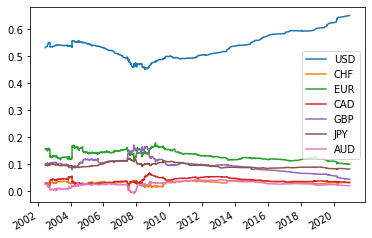

In [17]:
# Currency weights
df_msci_world_currency_weights = ols.params.transpose()
df_msci_world_currency_weights = df_msci_world_currency_weights.rename(msci_constituent_currency)
df_msci_world_currency_weights = df_msci_world_currency_weights.groupby(df_msci_world_currency_weights.index).sum()
df_msci_world_currency_weights = df_msci_world_currency_weights.transpose()

# Save to CSV
df_msci_world_currency_weights.to_csv('MSCIWorldCurrencyWeights.csv')

# Relevant currencies
df_msci_world_currency_weights = df_msci_world_currency_weights[['USD', 'CHF', 'EUR', 'CAD', 'GBP', 'JPY', 'AUD']]
df_msci_world_currency_weights = df_msci_world_currency_weights[df_msci_world_currency_weights!=0].dropna()
df_msci_world_currency_weights.plot()
plt.savefig('Plots/MSCIWorld_FX_Weights_360DAverage.jpg', dpi=300)


### Now create the partially hedged MSCI World index
Basis is the MSCI World total return index denoted in CHF

In [18]:
# Prepare data to build the hedged portfolio

# We can ignore fx forward margin according to Nicola Grass. Therefore set it to 0.
backtest_fx_margin = 0

# All months included in the backtest
months = df_msci_world_chf_m.index
backtest_start = '2002-12-31'
months = months[months >= backtest_start]

# Dataframe of all assets that can be invested in

# First FX positions. FX return is the spot rate of time t / forward rate of t-1 minus 1
backtest_asset_returns = df_fx_direct_m / df_f_m.shift() - 1

# Add MSCI World total return index
backtest_asset_returns['MSCI World'] = np.log(df_msci_world_chf_m).diff()

# Only relevant months
backtest_asset_returns = backtest_asset_returns.loc[months,:]

# Note that these returns are log returns, but they need to be simple returns to calculate cross section 
# portfolio returns
# backtest_asset_returns = np.exp(backtest_asset_returns) - 1 ### Somehow this gives me an error, therefore use
# inefficient method below
for r in backtest_asset_returns.index:
    for c in backtest_asset_returns.columns:
        backtest_asset_returns.loc[r,c] = np.exp(backtest_asset_returns.loc[r,c]) - 1

In [19]:
# Now determine the portfolio weights

# Empty df to store asset weights
backtest_partial_hedge_weights = pd.DataFrame(0, index=months, columns=backtest_asset_returns.columns)

# Hedge ratios from rolling regression above. Resample to monthly.
backtest_partial_hedge_ratios = df_msci_world_currency_weights.resample('M').last()

# Only the cyclical currencies are hedged
for month in months:
    # Only the cyclical currencies are hedged
    backtest_partial_hedge_weights.loc[month, 'EURCHF'] = -backtest_partial_hedge_ratios.loc[month,'EUR']
    backtest_partial_hedge_weights.loc[month, 'CADCHF'] = -backtest_partial_hedge_ratios.loc[month,'CAD']
    backtest_partial_hedge_weights.loc[month, 'GBPCHF'] = -backtest_partial_hedge_ratios.loc[month,'GBP']
    backtest_partial_hedge_weights.loc[month, 'AUDCHF'] = -backtest_partial_hedge_ratios.loc[month,'AUD']
    
    # Weight of MSCI World is always 1
    backtest_partial_hedge_weights.loc[month, 'MSCI World'] = 1
    
# Normalize asset weights to 1
backtest_partial_hedge_weights_absolute = np.abs(backtest_partial_hedge_weights)

# Multiply fx positions with margin %
backtest_partial_hedge_weights_absolute[df_fx_direct_m.columns] = backtest_partial_hedge_weights[df_fx_direct_m.columns]*backtest_fx_margin

# Total weights
backtest_partial_hedge_weights_absolute = backtest_partial_hedge_weights_absolute.sum(axis=1)

# Final weights
backtest_partial_hedge_weights = backtest_partial_hedge_weights.divide(backtest_partial_hedge_weights_absolute, axis='rows')

In [20]:
# Determine partially hedged MSCI World returns

# Returns are weights of previous period * return of asset
backtest_partial_hedge_returns = backtest_partial_hedge_weights.shift(1) * backtest_asset_returns
backtest_partial_hedge_returns = backtest_partial_hedge_returns.sum(axis=1)

# Change back to log returns to aggregate over time
backtest_partial_hedge_returns = np.log(1+backtest_partial_hedge_returns)

# Create index by multiplying 100 with 1 + simple return over time???
backtest_partial_hedge = 100*(np.exp(backtest_partial_hedge_returns.cumsum()))

## Optimized Hedge Ratio

## Evaluate Performance

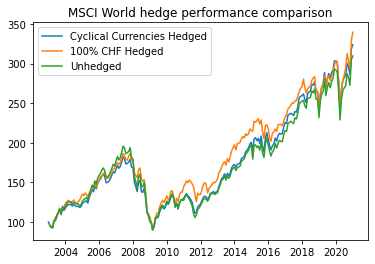

In [21]:
# Compare with 100% CHF hedged MSCI World
backtest_benchmark_hedged_msci_world_returns = np.log(df_msci_world_h_chf_m['M0WOHCHF Index'].loc[backtest_partial_hedge.index]).diff()
backtest_benchmark_hedged_msci_world = 100*(np.exp(backtest_benchmark_hedged_msci_world_returns.cumsum()))

# Compare with unhedged MSCI World
backtest_benchmark_unhedged_msci_world_returns = np.log(df_msci_world_chf_m.loc[backtest_partial_hedge.index]).diff()
backtest_benchmark_unhedged_msci_world = 100*(np.exp(backtest_benchmark_unhedged_msci_world_returns.cumsum()))

plt.plot(backtest_partial_hedge)
plt.plot(backtest_benchmark_hedged_msci_world)
plt.plot(backtest_benchmark_unhedged_msci_world)

plt.title('MSCI World hedge performance comparison')
plt.legend(['Cyclical Currencies Hedged', '100% CHF Hedged', 'Unhedged'])
plt.savefig('Plots/MSCI_World_hedge_comparison.jpg', dpi=300)


In [22]:
# Sharpe Ratio
def sharpe_ratio(return_series, risk_free_rate_df, return_series_currency='CHF'):
    '''
    Calculates sharpe ratio based on continuous returns.
    Returns: sharpe ratio, discrete annualized return, annualized volatility
    '''

    # Drop NA
    return_series = return_series.dropna()
    
    # Select the relevant risk free rate
    risk_free_rate = risk_free_rate_df[return_series_currency]
    
    # Change annualized risk free rate to right rate of return period
    return_days = return_series.index - return_series.index.shift(-1)
    return_days = return_days.days
    
    # Change to continuous for duration change
    risk_free_rate = np.log(risk_free_rate+1)
    
    # Change to risk free rate of number of days
    risk_free_rate = risk_free_rate.loc[return_series.index] * return_days / 365
    
    # Excess returns
    excess_returns = return_series - risk_free_rate
    
    # Annualized excess return
    total_excess_return = sum(excess_returns)
    total_years = excess_returns.index[-1] - excess_returns.index[0]
    total_years = total_years.days/365
    annualized_excess_return = total_excess_return / total_years
    
    # Annualized return
    annualized_return = np.exp(sum(return_series) / total_years) - 1
    
    # Annualized volatility. Frequency of returns is monthly, so multiply with sqrt(12)
    annualized_volatility = excess_returns.std() * np.sqrt(12)
    
    # Sharpe Ratio
    sharpe_ratio = annualized_excess_return / annualized_volatility
    
    return sharpe_ratio, annualized_return, annualized_volatility

# Create a table of results
index_performance = pd.DataFrame(columns=['Unhedged', 'Partial Hedge', '100% CHF Hedged'], index=['Sharpe Ratio', 'Annualized Return', 'Annualized Volatility'])
index_performance['Unhedged'] = sharpe_ratio(backtest_benchmark_unhedged_msci_world_returns, df_r_m)
index_performance['Partial Hedge'] = sharpe_ratio(backtest_partial_hedge_returns, df_r_m)
index_performance['100% CHF Hedged'] = sharpe_ratio(backtest_benchmark_hedged_msci_world_returns, df_r_m)

index_performance

,Unhedged,Partial Hedge,100% CHF Hedged
Sharpe Ratio,0.399226,0.454333,0.473068
Annualized Return,0.065072,0.067417,0.070581
Annualized Volatility,0.151687,0.138093,0.138916


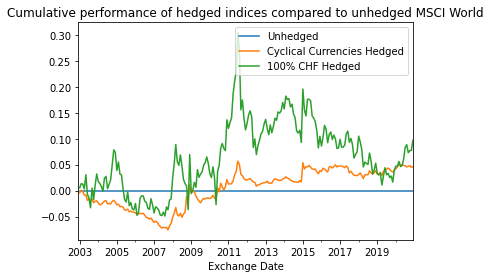

In [23]:
# Comparison of performance of hedged indices compared to unhedged indices
unhedged_outperformance = backtest_benchmark_unhedged_msci_world / backtest_benchmark_unhedged_msci_world -1
partial_hedge_outperformance = backtest_partial_hedge / backtest_benchmark_unhedged_msci_world - 1
full_hedge_outperformance = backtest_benchmark_hedged_msci_world / backtest_benchmark_unhedged_msci_world - 1

unhedged_outperformance.plot()
partial_hedge_outperformance.plot()
full_hedge_outperformance.plot()

plt.title('Cumulative performance of hedged indices compared to unhedged MSCI World')
plt.legend(['Unhedged', 'Cyclical Currencies Hedged', '100% CHF Hedged'])